# Assessment instructions

The objective of this assessment is to prepare a report based on a mini "research project" of your choice. You can select any of the projects we suggest below, or if you can pursue an idea of your own if that's what you prefer. 

The report should consist of 3 to 5 figures of your creation, using the code and analysis techniques you've learnt throughout the tutorials. You should write no more than two pages of text discussing what your figures show in relation to your research project topic. A good figure will have:

 - Labels and units for the axis and colorbar (if there is one)
 - Descriptive title
 - If needed, appropriate colormap selection
 - Clear showcase of information you discuss in the text

For the accompanying text, do a bit of research on the topic to write a brief introduction, and then describe your results illustrated by the figures. Finish the report with a brief conclusion of your findings.

You can read the papers suggested in the projects and take inspiration from their figures for your analysis. Remember that you can use CoPilot for coding, or even copy and paste code from the tutorials!

The data available for you to use includes:
 - Model's bathymetry -> `data/access-om2_depth.nc`
 - 3D oxygen fields, averaged during the period 2000-2018 -> `data/access-om2_o2_avg_2000-2018.nc`
 - Sea ice concentration seasonal cycle for the period 2000-2018 -> `data/access-om2_sea_ice_cc_clim_2000-2018.nc`
 - Sea level averaged for the period 2000-2018 -> `data/access-om2_sea_level_avg_2000-2018.nc`
 - 3D temperature and salinity fields, averaged during the period 2000-2018 -> `data/access-om2_temp_salt_avg_2000-2018.nc`
 - 3D temperature and salinity fields and mixed layer depth seasonal cycle for the period 2000-2018 -> `data/access-om2_temp_salt_mld_clim_2000-2018.nc`
 - 3D zonal and meridional velocities, averaged during the period 2000-2018 -> `data/access-om2_u_v_avg_2000-2018.nc`

# Research projects

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Comparison of temperature and salinity between West and East Antarctica

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 20%; max-width: 500px;">
    <img src="images/ant_melt.png" width="100%" />
</div>

### Background

The loss of ice from the Antarctic Ice Sheet makes a substantial contribution to sea level rise. At present, the West Antarctic Ice Sheet (WAIS) has been loosing mass in a way the East Antarctic has not (take a look at the figure on the right from [Smith et al. 2020](https://www.science.org/doi/10.1126/science.aaz5845)). This mass loss is in part due to the melting of the ice shelves from below by a warmer ocean. The higher vulnerability of WAIS to melt has been linked to the particular configuration of the continental shelf and the ocean circulation : here, Circumpolar Deep Water is able to intrude onto the continental shelf and access the ice shelf cavities. 

Suggested reading: [Smith et al. (2020)](https://www.science.org/doi/10.1126/science.aaz5845), [IMBIE team (2018)](https://www.nature.com/articles/s41586-018-0179-y), [Nakayama et al. (2018)](https://www.nature.com/articles/s41467-018-05813-1)


### Research objective

Use the temperature and salinity fields from the ACCESS-OM2 model to compare the temperature and salinity of the continental shelf at West Antarctica vs the one at East Antarctica. The file `data/access_om2_temp_salt_avg_2000-2018.nc` contains these variables averaged over the 2000-2018 period. Remember that `temp` is conservative temperature and comes in units of Kelvin, and `salt` is practical salinity and comes in units of PSU. Potential ideas for your figures are:
 - TS diagrams
 - Maps of temperature/salinity at different depths
 - Cross-sections
 - Temperature/salinity profiles


### Tips

You will have to be able to select the continental shelf in West Antarctica and East Antarctica. Selecting the continental shelf is slightly more nuanced than just selecting a latitude/longitude box. Take inspiration from the second class, where we looked the Antarctic Bottom Water layer selecting those densities larger than 28.27 $kg/m^3$: if the continental shelf is defined as the area shallower than 1000m, you can use the `xarray.where()` function to select the continental shelf. For example:

```
xr.where(ht<1000, temp, np.nan)
```

where we are keeping temperature values where the depth `ht` is less than a 1000, otherwise we write `NaN`s. 

Before doing the above, you will want to have pre-selected a `temp_WA` variable for the West Antarctic region, and a `temp_EA` for the East Antarctic region. Look at the figure from Smith et al. 2020 to do the selection!

In [3]:
# Open datasets 
ds = xr.open_dataset('data/access-om2_temp_salt_avg_2000-2018.nc')
# Convert temp from Kelvin to C
ds['temp'] = ds['temp']-273.15
depth = xr.open_dataset('data/access-om2_depth.nc')

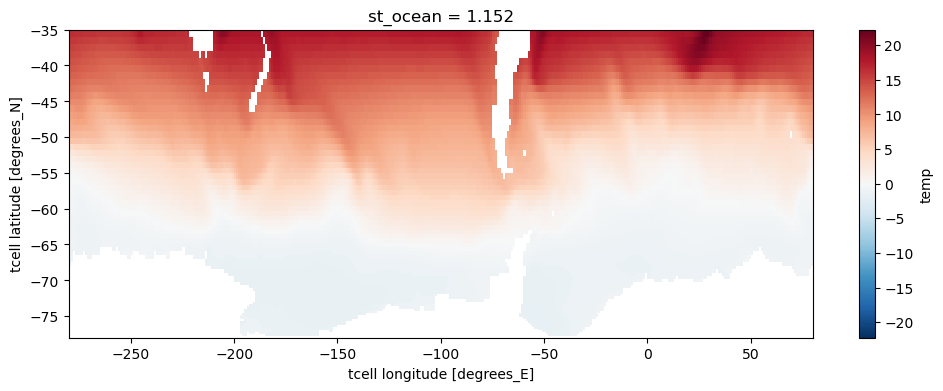

In [10]:
# See what the region we have is
ds['temp'].isel(st_ocean = 0).plot(figsize = (12,4));

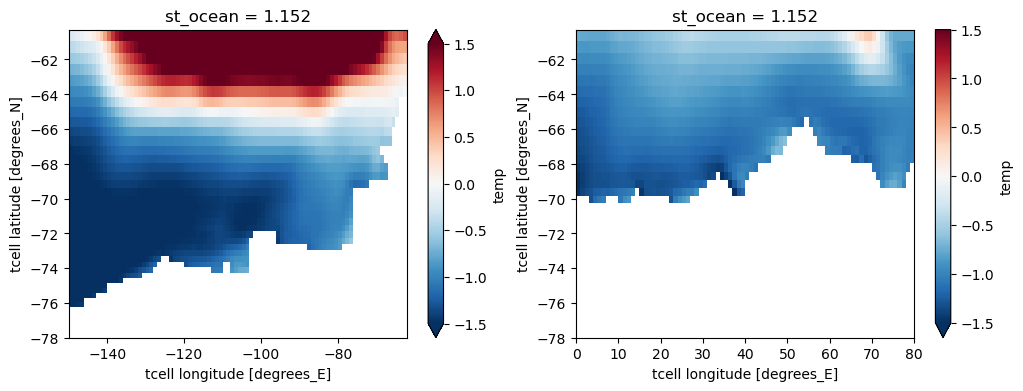

In [9]:
# Test a selection of West and East Antarctica
fig, axs = plt.subplots(1, 2, figsize = (12,4))
ds['temp'].isel(st_ocean = 0).sel(xt_ocean = slice(-150, -62), yt_ocean = slice(None, -60)).plot(ax = axs[0], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ds['temp'].isel(st_ocean = 0).sel(xt_ocean = slice(0, None), yt_ocean = slice(None, -60)).plot(ax = axs[1], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r');

In [6]:
ds_WA = ds.sel(xt_ocean = slice(-150, -62), yt_ocean = slice(None, -60))
ds_EA = ds.sel(xt_ocean = slice(0, None), yt_ocean = slice(None, -60))
# Do the same selection for the depths
depth_WA = depth['ht'].sel(xt_ocean = slice(-150, -62), yt_ocean = slice(None, -60))
depth_EA = depth['ht'].sel(xt_ocean = slice(0, None), yt_ocean = slice(None, -60))

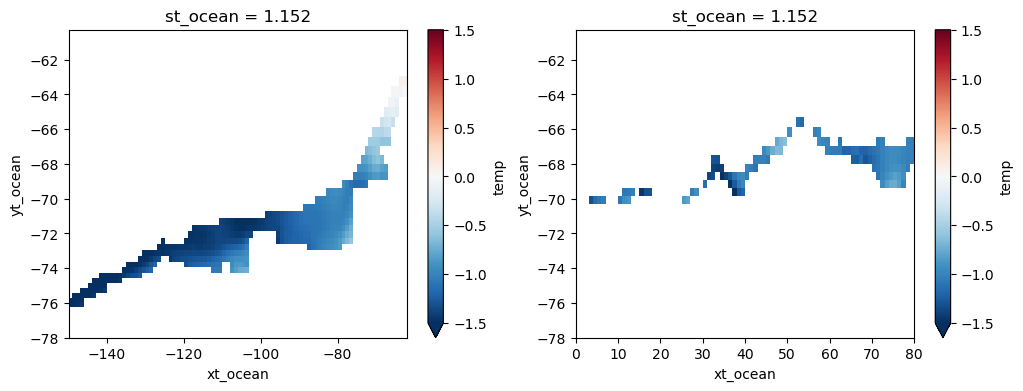

In [8]:
# Test if our where works
ds_WA_shelf = xr.where(depth_WA < 1000, ds_WA, np.nan)
ds_EA_shelf = xr.where(depth_EA < 1000, ds_EA, np.nan)
fig, axs = plt.subplots(1, 2, figsize = (12,4))
ds_WA_shelf['temp'].isel(st_ocean = 0).plot(ax = axs[0], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ds_EA_shelf['temp'].isel(st_ocean = 0).plot(ax = axs[1], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r');

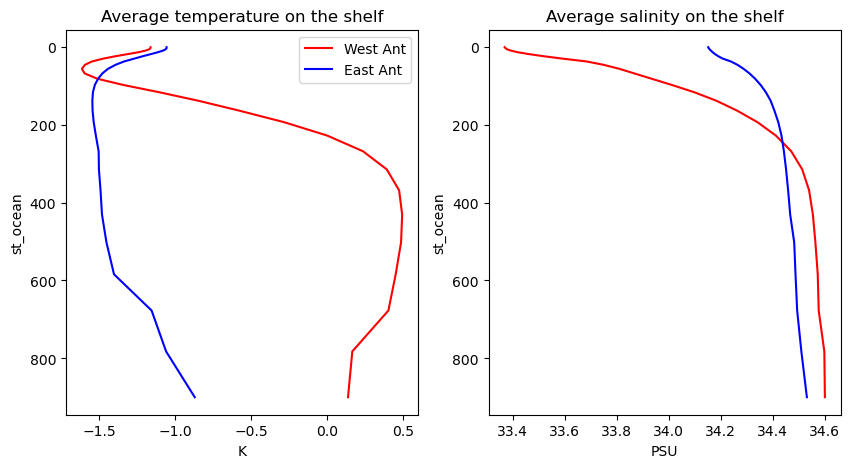

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
ds_WA_shelf['temp'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0], y = 'st_ocean', color = 'red', label = 'West Ant')
ds_EA_shelf['temp'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0], y = 'st_ocean', color = 'blue', label = 'East Ant')
axs[0].legend()
ds_WA_shelf['salt'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1], y = 'st_ocean', color = 'red')
ds_EA_shelf['salt'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1], y = 'st_ocean', color = 'blue')
for ax in axs:
    ax.invert_yaxis()
axs[0].set_title('Average temperature on the shelf')
axs[1].set_title('Average salinity on the shelf')
axs[0].set_xlabel('K')
axs[1].set_xlabel('PSU');

In [12]:
# Calculate pressure and absolute salinity to make a TS
p = gsw.p_from_z(-ds['st_ocean'], ds['yt_ocean'])
SA = gsw.SA_from_SP(ds['salt'], p, ds['xt_ocean'], ds['yt_ocean'])
SA_WA = SA.sel(xt_ocean = slice(-150, -62), yt_ocean = slice(None, -60))
SA_EA = SA.sel(xt_ocean = slice(0, None), yt_ocean = slice(None, -60))

In [13]:
# Get temperature/salinity edges from the axis
temp_range = [-2, 4]
salt_range = [32, 35]
# Get an array of size 50 between the edges
temp_axis = np.linspace(temp_range[0], temp_range[1], 50)
salt_axis = np.linspace(salt_range[0], salt_range[1], 50)
# Create a grid and calculate potential density
temp_axis, salt_axis = np.meshgrid(temp_axis, salt_axis)
density_reference = gsw.sigma0(salt_axis, temp_axis)

c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


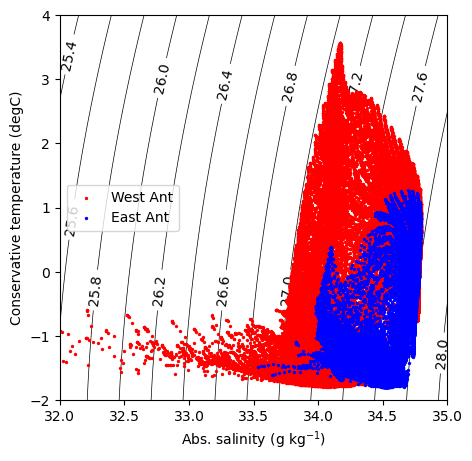

In [14]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))

pref = ax.contour(salt_axis, temp_axis, density_reference, levels = 15, 
                  colors = ['k'], linewidths = [.5], zorder = 0)
plt.clabel(pref, inline = True, zorder = 0)

ax.scatter(SA_WA, ds_WA['temp'], color = 'r', s = 2, label = 'West Ant')
ax.scatter(SA_EA, ds_EA['temp'], color = 'b', s = 2, label = 'East Ant')

ax.set_xlim(32, None)
ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (degC)');
ax.legend();

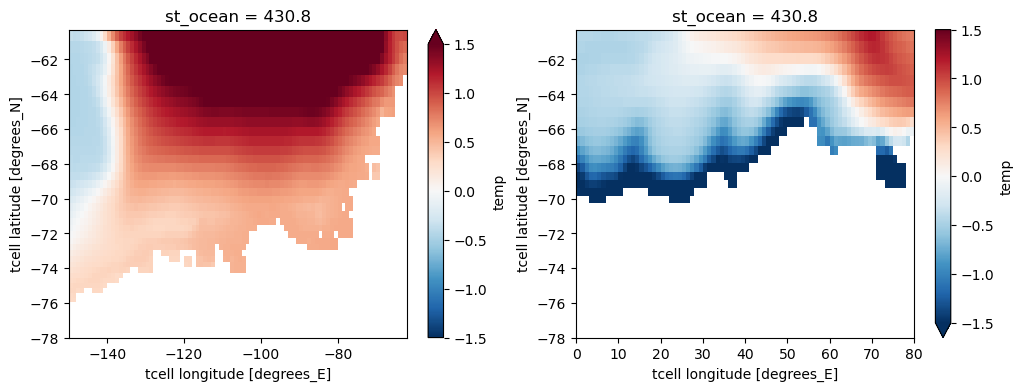

In [15]:
# The largest difference in temps seems to be at 400m (look at temperature profile). Let's plot maps at this depth
fig, axs = plt.subplots(1, 2, figsize = (12,4))
ds['temp'].sel(st_ocean = 400, method = 'nearest').sel(xt_ocean = slice(-150, -62), yt_ocean = slice(None, -60)).plot(ax = axs[0], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ds['temp'].sel(st_ocean = 400, method = 'nearest').sel(xt_ocean = slice(0, None), yt_ocean = slice(None, -60)).plot(ax = axs[1], vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r');

## Identifying Southern Ocean fronts from sea level

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 20%; max-width: 500px;">
    <img src="images/acc_fronts_schem.png" width="100%" />
</div>

### Background

An oceanographic front is a sharp boundary that separates two areas with water masses of different characteristics. Fronts are a really important feature of the ocean circulation: they sustain strong currents, they give rise to instabilities and eddies and they are usually biologically productive regions, rich in nutrients (see the figure on the left from [Chapman et al. (2020)](https://www.nature.com/articles/s41558-020-0705-4). These fronts also exhert an obstacle (a barrier) for tracers to move from one side to the other. 

Within the Southern Ocean there are several of these fronts. Three of the most important ones are the Subantarctic Front, the Polar Front and the Southern ACC Front. Traditionally, these have been identified from sea surface height data, using a specific value of an SSH contour associated to each front. However, for some applications, like looking at changes in frontal position throughout time, instead of choosing a fixed value, another definition may be used based on the *gradient* of sea level. Essentially identifying a front as a region of *large change in small distances* rather than a fixed value. Remember that, like we saw in `2_SO_circulation_from_geostrophy.ipynb`, regions with large gradients are associated to strong currents!

Suggested reading: [Chapman et al. (2020)](https://www.nature.com/articles/s41558-020-0705-4), [Orsi et al (1995)](https://www.sciencedirect.com/science/article/pii/096706379500021W?via%3Dihub), [Sokolov and Rintoul (2007)](https://doi.org/10.1029%2F2006JC004072).

### Research objective

Use the `sea_level` variable from the model and look at the position of the three fronts using the following contours: -0.51 for the Subantarctic Front (SAF); -0.96 for the Polar Front (PF) and -1.5 for the Southern ACC Front (SB). Use temperature, salinity and oxygen in `data/access_om2_o2_avg_2000-2018.nc` to look at the subsurface beneath those front definitions. You can find the data in  `data/access_om2_sea_level_avg_2000-2018.nc` and `data/access_om2_temp_salt_avg_2000-2018.nc`. Potential ideas for your figures are:
- Maps of frontal position as a contour and surface temperature/salinity or oxygen. You can make different maps for different depths.
- Cross-section of temp/salt/oxygen to see the vertical structure

### Tips

If you choose to do maps, use the `stereographic_plot` function we introduced in Week 5. For your cross sections, see if you can overlay on them the location of the fronts. 

### Example solution

In [16]:
ds_sl =  xr.open_dataset('data/access-om2_sea_level_avg_2000-2018.nc')
ds_ts =  xr.open_dataset('data/access-om2_temp_salt_avg_2000-2018.nc')
ds_ts['temp'] = ds_ts['temp']-273.15
ds_o2 =  xr.open_dataset('data/access-om2_o2_avg_2000-2018.nc')

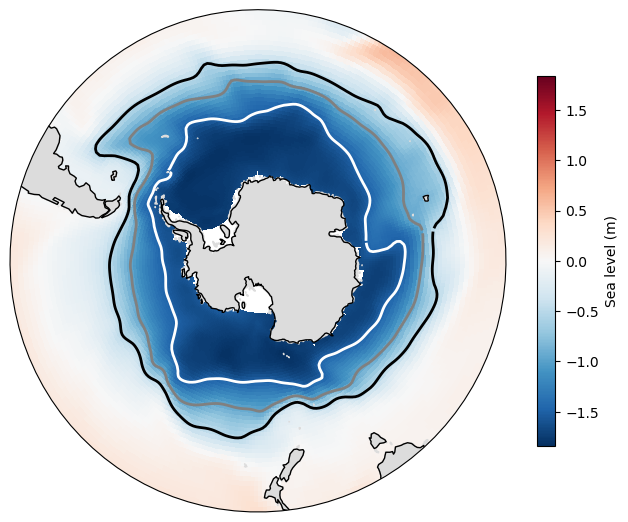

In [17]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)

ds_sl['sea_level'].plot.pcolormesh(transform = ccrs.PlateCarree(),
                        cbar_kwargs = {'label': 'Sea level (m)', 'shrink':.6})
ds_sl['sea_level'].plot.contour(levels = [-0.51, -0.96, -1.5], colors = ['white', 'grey', 'black'], 
                                linewidths = [2], transform = ccrs.PlateCarree());

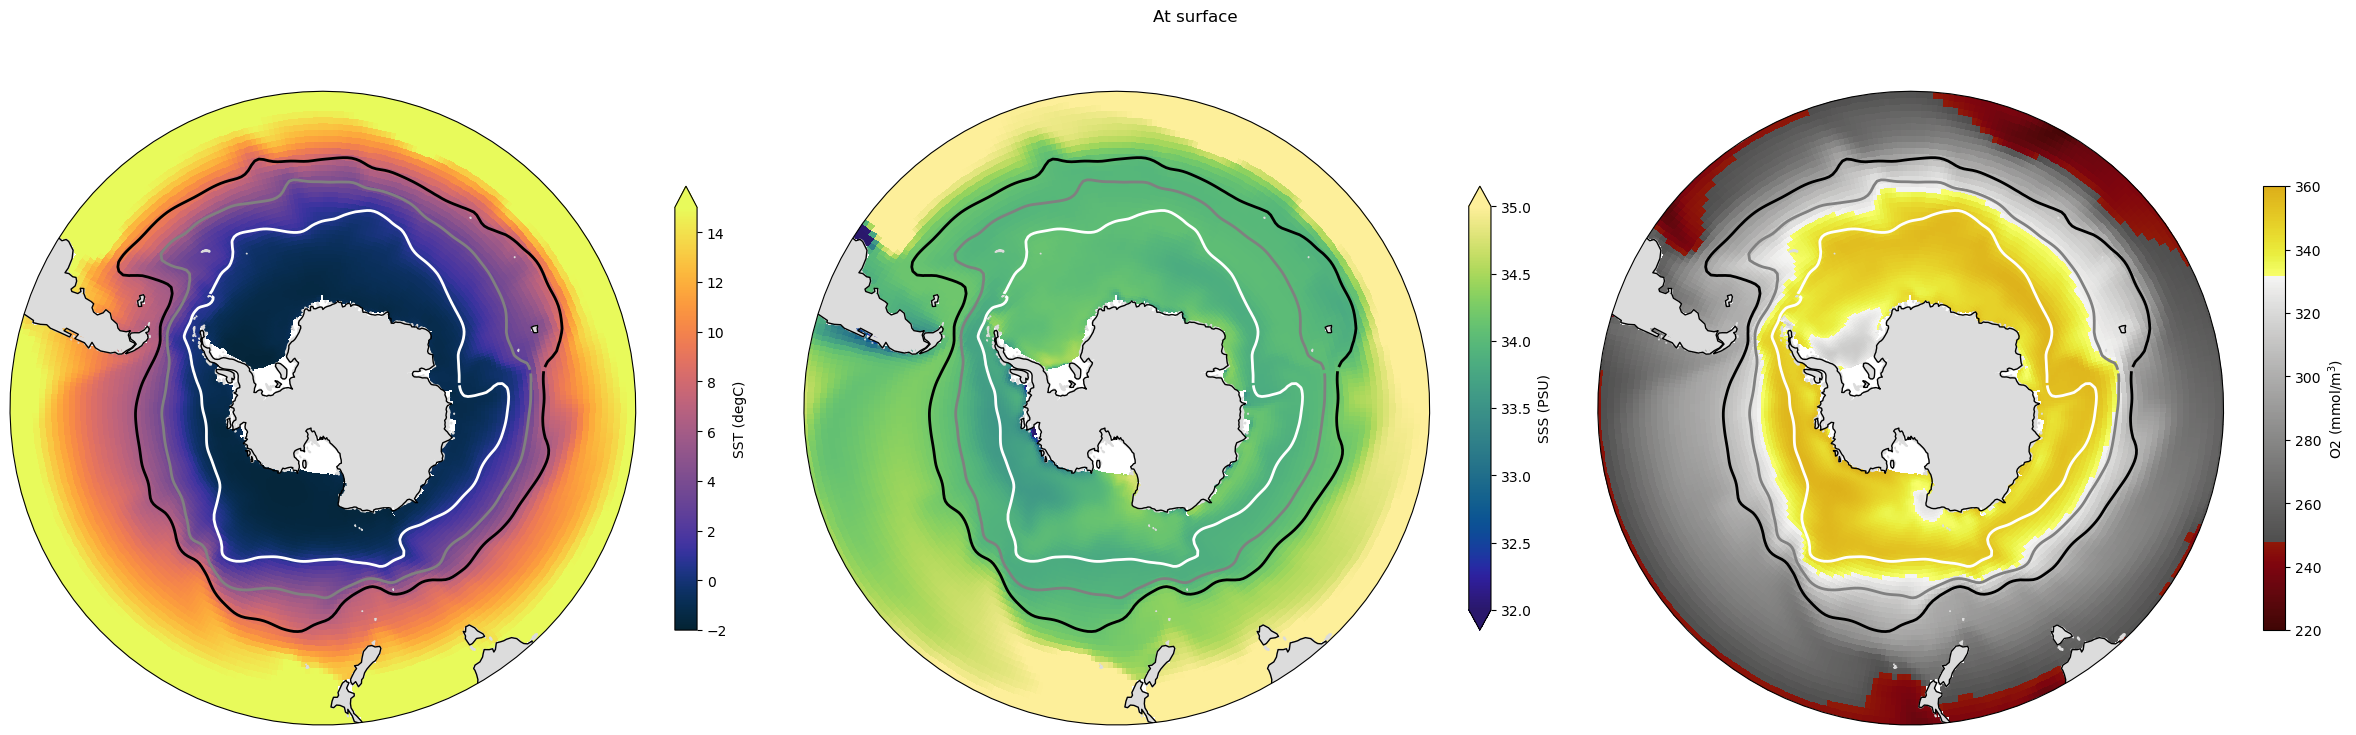

In [18]:
fig = plt.figure(figsize = (24, 8))
axs = [fig.add_subplot(131, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(132, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(133, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

ds_ts['temp'].isel(st_ocean = 0).plot.pcolormesh(ax = axs[0], vmin = -2, vmax = 15, cmap = cm.cm.thermal,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'SST (degC)', 'shrink':.6})
ds_ts['salt'].isel(st_ocean = 0).plot.pcolormesh(ax = axs[1], vmin = 32, vmax = 35, cmap = cm.cm.haline,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'SSS (PSU)', 'shrink':.6})
ds_o2['o2'].isel(st_ocean = 0).plot.pcolormesh(ax = axs[2], vmin = 220, vmax = 360, cmap = cm.cm.oxy,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'O2 (mmol/m$^3$)', 'shrink':.6})

for ax in axs:
    ds_sl['sea_level'].plot.contour(ax = ax, levels = [-0.51, -0.96, -1.5], 
                                    colors = ['white', 'grey', 'black'], 
                                    linewidths = [2], transform = ccrs.PlateCarree())
fig.suptitle('At surface')
plt.tight_layout();

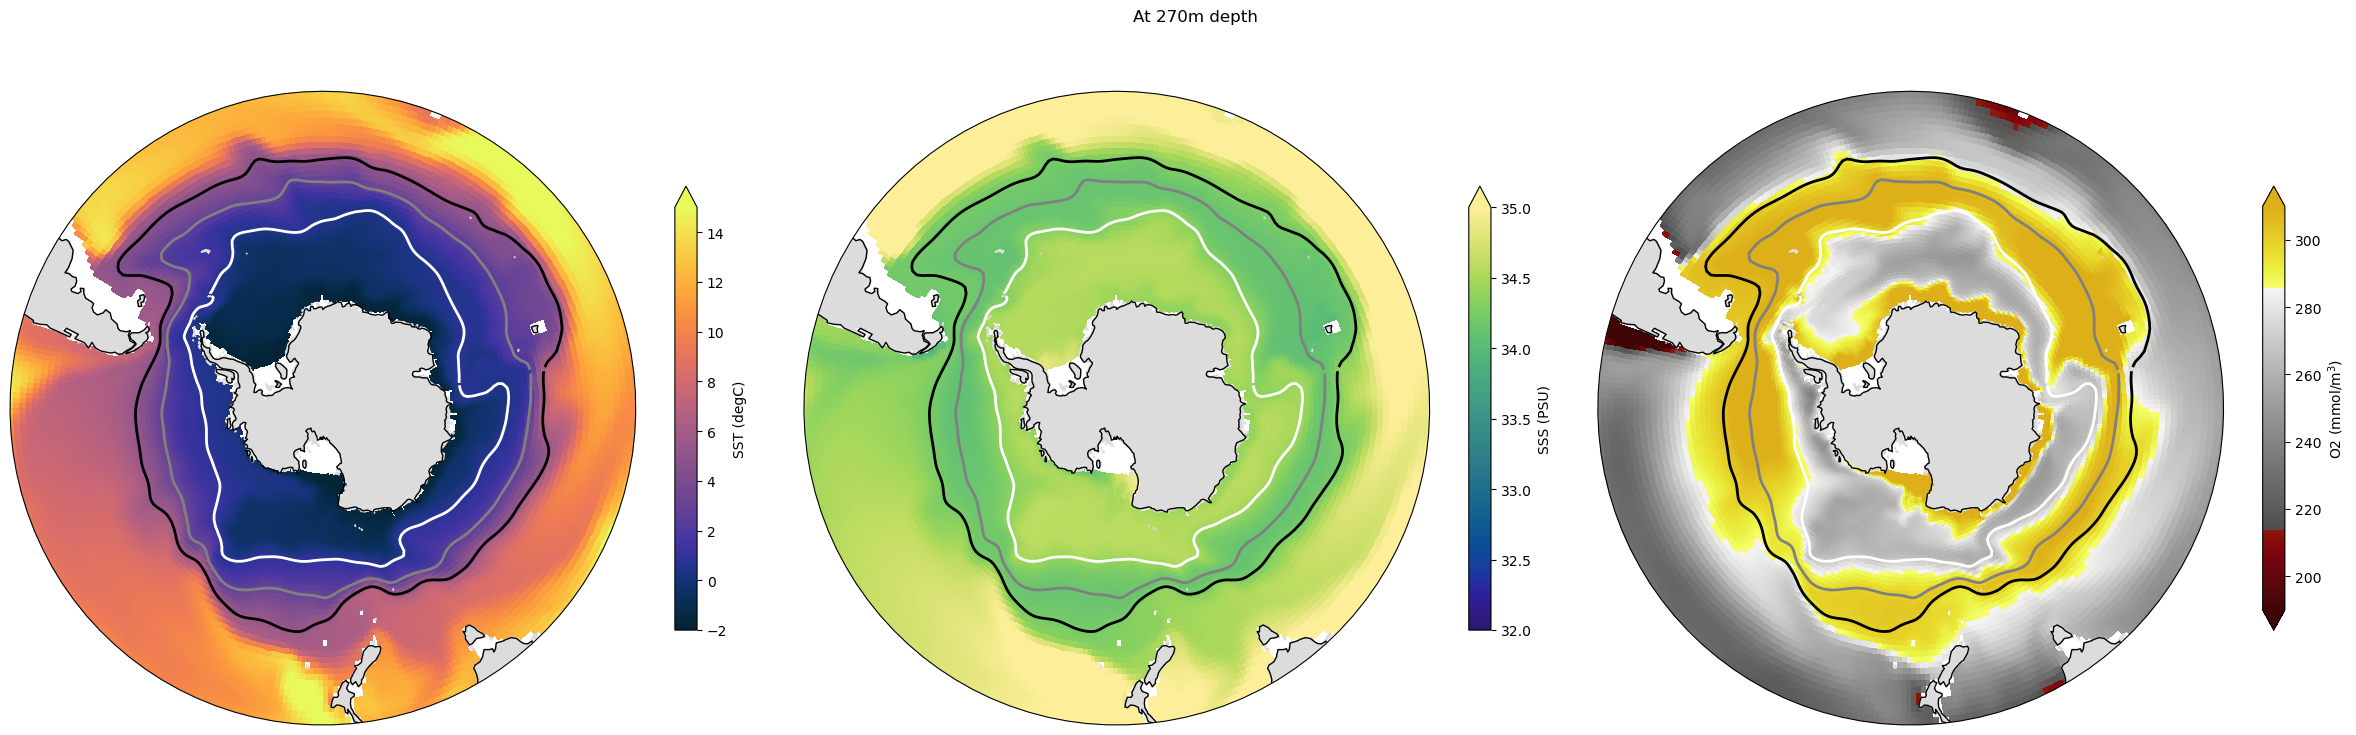

In [19]:
fig = plt.figure(figsize = (24, 8))
axs = [fig.add_subplot(131, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(132, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(133, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

ds_ts['temp'].isel(st_ocean = 19).plot.pcolormesh(ax = axs[0], vmin = -2, vmax = 15, cmap = cm.cm.thermal,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'SST (degC)', 'shrink':.6})
ds_ts['salt'].isel(st_ocean = 19).plot.pcolormesh(ax = axs[1], vmin = 32, vmax = 35, cmap = cm.cm.haline,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'SSS (PSU)', 'shrink':.6})
ds_o2['o2'].isel(st_ocean = 19).plot.pcolormesh(ax = axs[2], vmin = 190, vmax = 310, cmap = cm.cm.oxy,
                                                 transform = ccrs.PlateCarree(), 
                                                 cbar_kwargs = {'label': 'O2 (mmol/m$^3$)', 'shrink':.6})

for ax in axs:
    ds_sl['sea_level'].plot.contour(ax = ax, levels = [-0.51, -0.96, -1.5], 
                                    colors = ['white', 'grey', 'black'], 
                                    linewidths = [2], transform = ccrs.PlateCarree())
fig.suptitle('At 270m depth');
plt.tight_layout();

In [20]:
abs_diff = np.abs(ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest') + 0.51)
saf_loc = ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest')[abs_diff.argmin().item()]['yt_ocean'].values

abs_diff = np.abs(ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest') + 0.96)
pf_loc = ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest')[abs_diff.argmin().item()]['yt_ocean'].values

abs_diff = np.abs(ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest') + 1.5)
sb_loc = ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest')[abs_diff.argmin().item()]['yt_ocean'].values

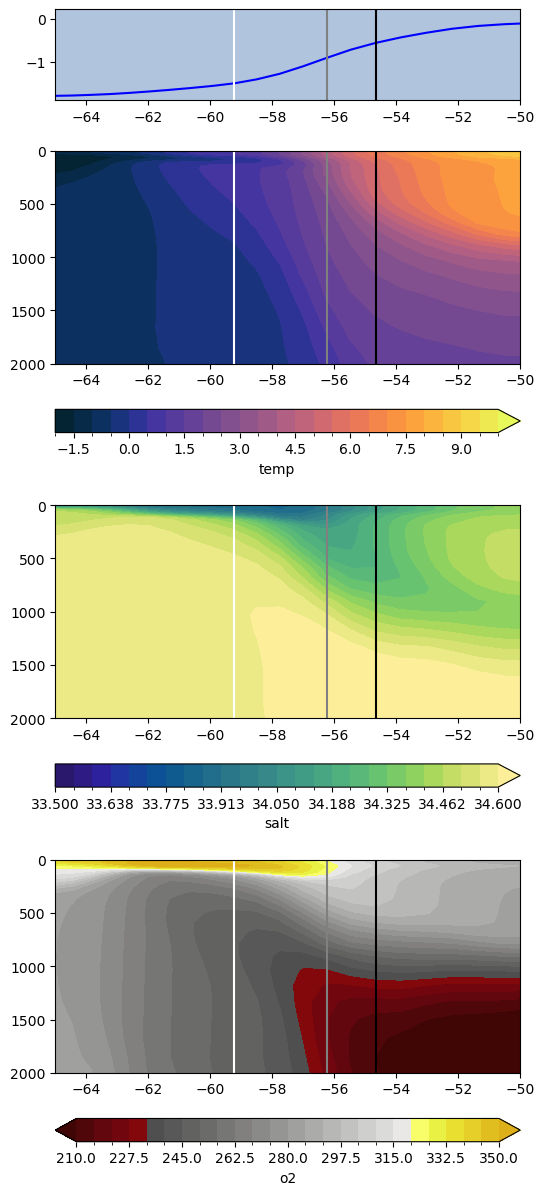

In [21]:
fig, axs = plt.subplots(4, 1, figsize = (6, 15), height_ratios = [.3,1,1,1])
axs[0].set_facecolor('lightsteelblue')
ds_sl['sea_level'].sel(xt_ocean = -200, method = 'nearest').plot(ax = axs[0], color = 'blue')
ds_ts['temp'].sel(xt_ocean = -200, method = 'nearest').plot.contourf(ax = axs[1], levels = 25, cmap = cm.cm.thermal,
                                                                     vmin = -2, vmax = 10,
                                                                     cbar_kwargs = {'orientation':'horizontal'})
ds_ts['salt'].sel(xt_ocean = -200, method = 'nearest').plot.contourf(ax = axs[2], levels = 25, cmap = cm.cm.haline,
                                                                     vmin = 33.5, vmax = 34.6,
                                                                     cbar_kwargs = {'orientation':'horizontal'})
ds_o2['o2'].sel(xt_ocean = -200, method = 'nearest').plot.contourf(ax = axs[3], levels = 25, cmap = cm.cm.oxy,
                                                                   vmin = 210, vmax = 350,
                                                                   cbar_kwargs = {'orientation':'horizontal'})
for ax in axs:
    ax.set_title('')
    ax.set_xlabel(''); 
    ax.set_ylabel('')
    ax.set_xlim(-65, -50)
    ax.axvline(x = saf_loc, color = 'k')
    ax.axvline(x = pf_loc, color = 'grey')
    ax.axvline(x = sb_loc, color = 'white')
    if ax != axs[0]:
        ax.invert_yaxis()
        ax.set_ylim(2000, 0)

## Three different shelf and Antarctic Slope Current regimes

### Background

The Antarctic Slope Current (ASC) is a quasi-circumpolar current that flows around Antarctica in an anti-clockwise direction. We say it is quasi-circumpolar because it is either absent or very weak in West Antarctica. It is a really important dynamical feature of the ocean circulation, because typically when there is a strong, established current, the exchange of water masses from either side becomes inhibited - in other words, the ASC acts as a barrier for open-ocean water masses to come onto the shelf. Remember that open-ocean water masses are usually warmer than the waters on shelf, and so this mediating role controls to a certain extant how much heat gets to the ice shelves. The lack (or weakness) of the ASC in West Antarctica is one of the reasons behind the vulnerability of this area and the increased melt rates observed here. 

The ASC's properties vary around the Antarctic margins, and it is usually classified into three distinct regimes: a surface intensified, a bottom intensified, and a reverse ASC, each associated to different T/S shelf structures. The different regimes are illustrated in the figure below from [Huneke et al. (2022)](https://journals.ametsoc.org/view/journals/phoc/52/3/JPO-D-21-0143.1.xml):

<p align="center">
<img src="images/asc_regimes.png" width="70%"/>
</p>

Suggested reading: [Thompson et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018RG000624),[Huneke et al. (2022)](https://journals.ametsoc.org/view/journals/phoc/52/3/JPO-D-21-0143.1.xml).

### Research objective

Use the velocity, temperature and salinity fields to characterise the three different ASC regimes. These variables are in `data/access-om2_temp_salt_avg_2000-2018.nc` and `data/access-om2_u_v_avg_2000-2018.nc`, averaged for the 2000-2018 period. Use the information in the papers to select the regions where each of the regimes can be found. Potential ideas for your figures are:
 - Cross sections of temperature, salinity and density (which you can calculate from temperature and salinity)
 - Cross sections of velocities

### Tips

Use `xarray.sel()` to select the different *longitudes*. You can try with a single longitude, or averaging over a slice. Look at the tutorials from Week 4 and 5 for a refresher on cross sections.

### Example solution

In [22]:
# Open datasets 
ds_ts = xr.open_dataset('data/access-om2_temp_salt_avg_2000-2018.nc')
ds_uv = xr.open_dataset('data/access-om2_u_v_avg_2000-2018.nc')
# Convert temp from Kelvin to C
ds_ts['temp'] = ds_ts['temp']-273.15

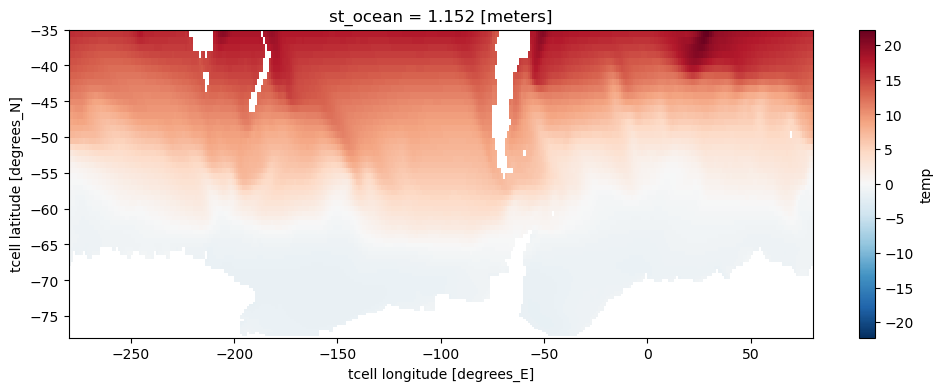

In [23]:
# See what the region we have is
ds_ts['temp'].isel(st_ocean = 0).plot(figsize = (12,4));

In [24]:
# Calculate potential density
p = gsw.p_from_z(-ds_ts['st_ocean'], ds_ts['yt_ocean'])
SA = gsw.SA_from_SP(ds_ts['salt'], p, ds_ts['xt_ocean'], ds_ts['yt_ocean'])
potential_density = gsw.sigma0(SA, ds_ts['temp'])

In [25]:
ds_ts_fresh = ds_ts.sel(xt_ocean = 40, method = 'nearest').sel(yt_ocean = slice(-69.5, -63))
ds_uv_fresh = ds_uv.sel(xu_ocean = 40, method = 'nearest').sel(yu_ocean = slice(-69.5, -63))
potential_density_fresh = potential_density.sel(xt_ocean = 40, method = 'nearest').sel(yt_ocean = slice(-69.5, -63))

ds_ts_warm = ds_ts.sel(xt_ocean = -100, method = 'nearest').sel(yt_ocean = slice(-73, -66))
ds_uv_warm = ds_uv.sel(xu_ocean = -100, method = 'nearest').sel(yu_ocean = slice(-73, -66))
potential_density_warm = potential_density.sel(xt_ocean = -100, method = 'nearest').sel(yt_ocean = slice(-73, -66))

ds_ts_dense = ds_ts.sel(xt_ocean = -50, method = 'nearest').sel(yt_ocean = slice(None, -67))
ds_uv_dense = ds_uv.sel(xu_ocean = -50, method = 'nearest').sel(yu_ocean = slice(None, -67))
potential_density_dense = potential_density.sel(xt_ocean = -50, method = 'nearest').sel(yt_ocean = slice(None, -67))

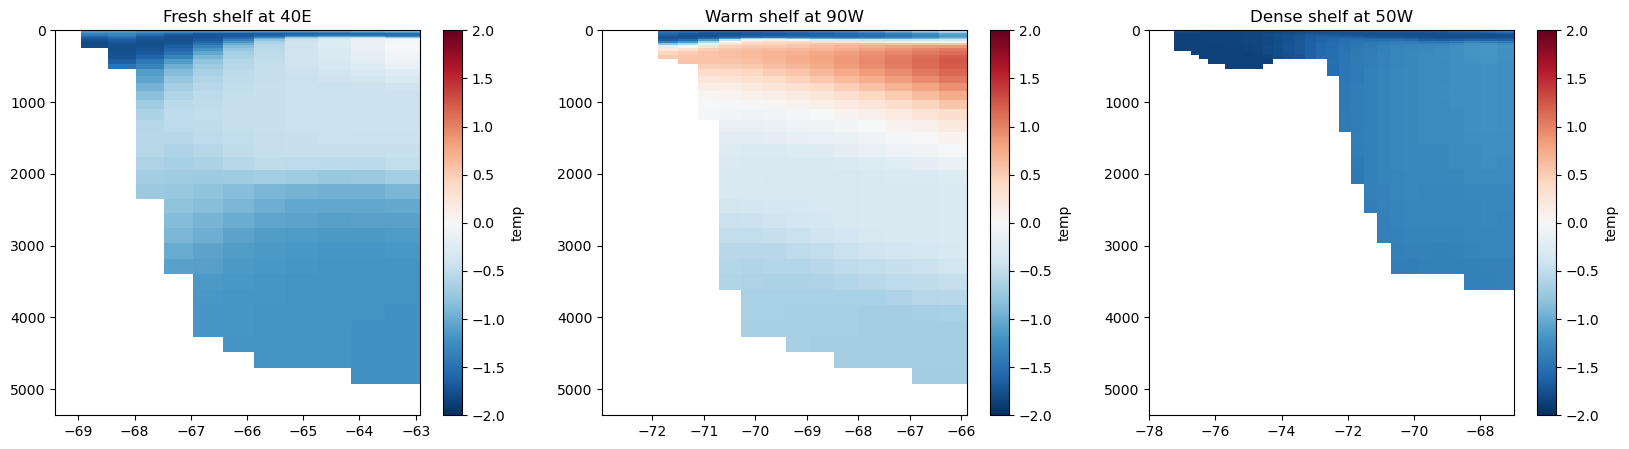

In [26]:
fig, axs = plt.subplots(1, 3, figsize = (20,5))
ds_ts_fresh['temp'].plot(ax = axs[0], vmin = -2, vmax = 2, cmap = 'RdBu_r')
axs[0].set_title('Fresh shelf at 40E')
ds_ts_warm['temp'].plot(ax = axs[1], vmin = -2, vmax = 2, cmap = 'RdBu_r')
axs[1].set_title('Warm shelf at 90W')
ds_ts_dense['temp'].plot(ax = axs[2], vmin = -2, vmax = 2, cmap = 'RdBu_r')
axs[2].set_title('Dense shelf at 50W')
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('');
    ax.set_xlabel('');

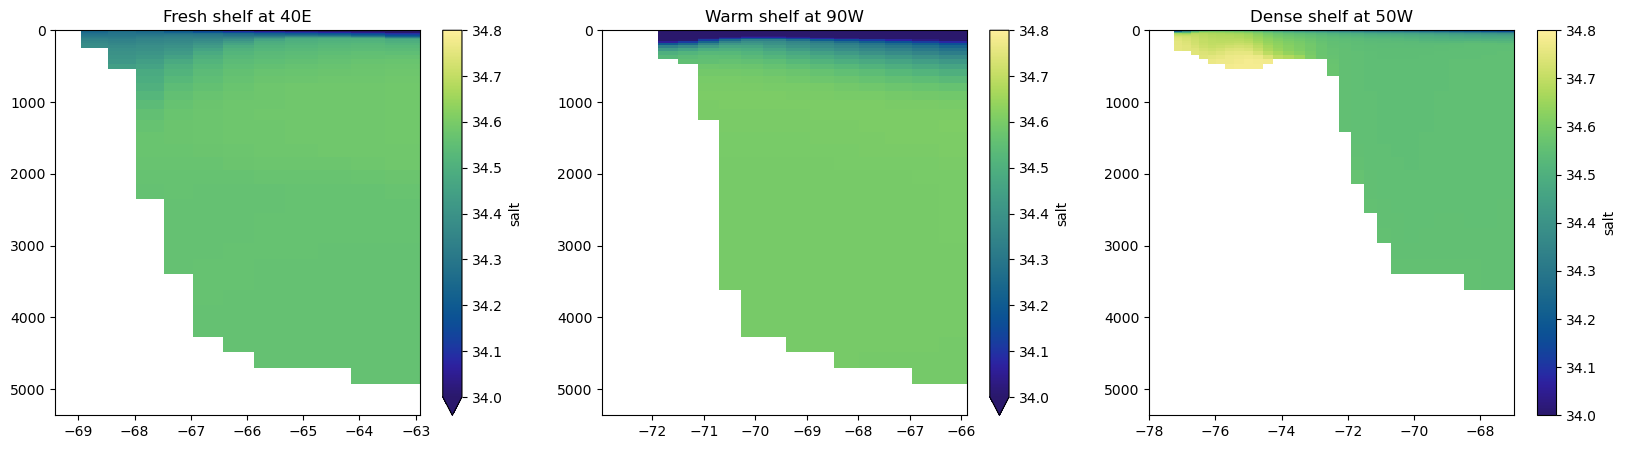

In [27]:
fig, axs = plt.subplots(1, 3, figsize = (20,5))
ds_ts_fresh['salt'].plot(ax = axs[0], vmin = 34, vmax = 34.8, cmap = cm.cm.haline)
axs[0].set_title('Fresh shelf at 40E')
ds_ts_warm['salt'].plot(ax = axs[1], vmin = 34, vmax = 34.8, cmap = cm.cm.haline)
axs[1].set_title('Warm shelf at 90W')
ds_ts_dense['salt'].plot(ax = axs[2], vmin = 34, vmax = 34.8, cmap = cm.cm.haline)
axs[2].set_title('Dense shelf at 50W')
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('');
    ax.set_xlabel('');

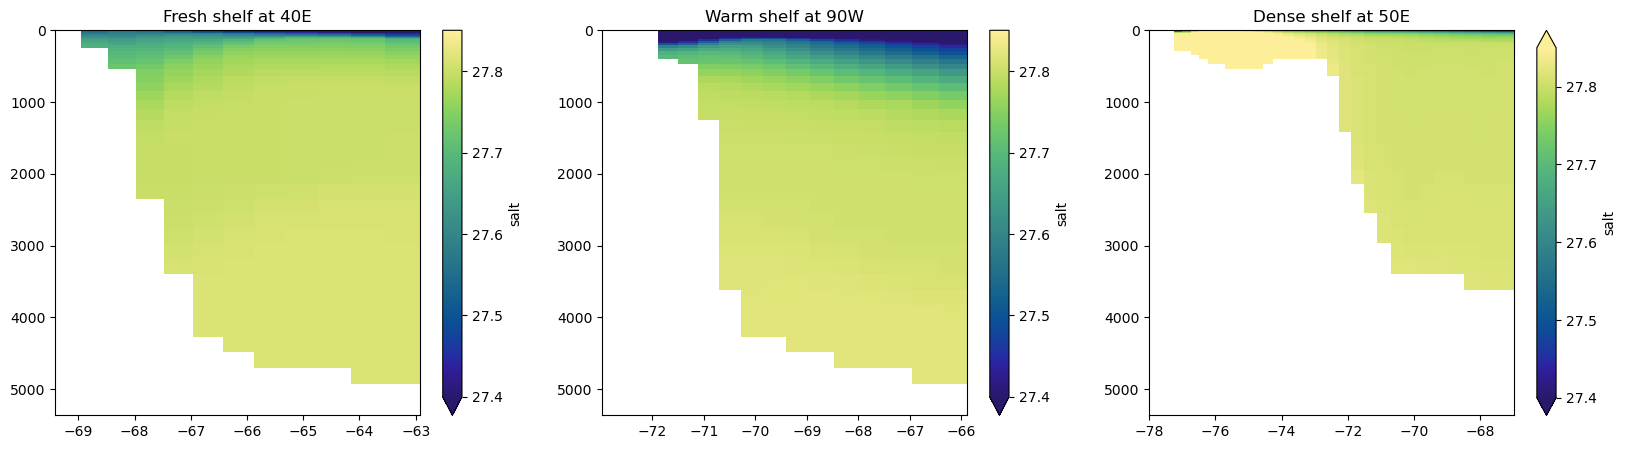

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (20,5))
potential_density_fresh.plot(ax = axs[0], vmin = 27.4, vmax = 27.85, cmap = cm.cm.haline)
axs[0].set_title('Fresh shelf at 40E')
potential_density_warm.plot(ax = axs[1], vmin = 27.4, vmax = 27.85, cmap = cm.cm.haline)
axs[1].set_title('Warm shelf at 90W')
potential_density_dense.plot(ax = axs[2], vmin = 27.4, vmax = 27.85, cmap = cm.cm.haline)
axs[2].set_title('Dense shelf at 50E')
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('');
    ax.set_xlabel('');

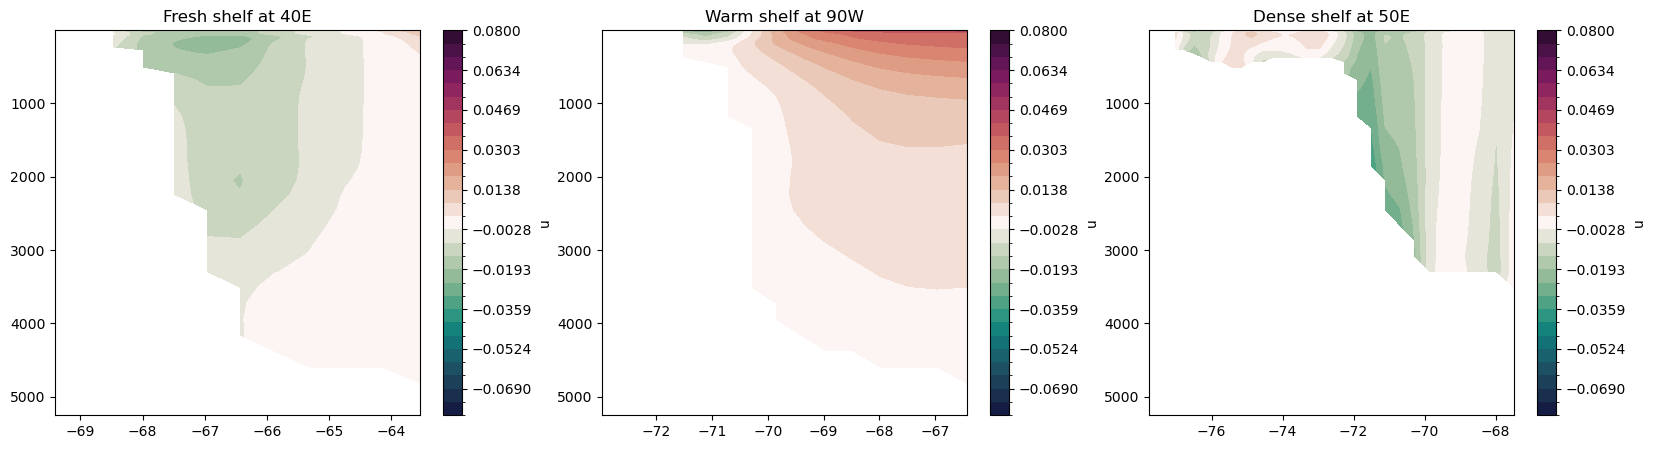

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (20,5))
ds_uv_fresh['u'].plot.contourf(ax = axs[0], vmin = -0.08, vmax = 0.08, levels = 30, cmap = cm.cm.curl)
axs[0].set_title('Fresh shelf at 40E')
ds_uv_warm['u'].plot.contourf(ax = axs[1], vmin = -0.08, vmax = 0.08, levels = 30, cmap = cm.cm.curl)
axs[1].set_title('Warm shelf at 90W')
ds_uv_dense['u'].plot.contourf(ax = axs[2], vmin = -0.08, vmax = 0.08, levels = 30, cmap = cm.cm.curl)
axs[2].set_title('Dense shelf at 50E')
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('');
    ax.set_xlabel('');

## Seasonality of the surface layer and open ocean polynyas

### Background

We have seen in previous classes how the formation of bottom waters (termed Antarctic Bottom Water) occurs in localised regions around the Antarctic margins. The complexity of the processes involved means that it is a process that few numerical models are able to reproduce accurately: most models produce bottom waters by open-ocean convection, large factories of bottom waters off-shelf in the Weddell and Ross Seas. Open-ocean convection is a phenomena that has rarely been observed: in fact, we have only observed it twice, in the event of the [Maud Rise polynya](https://earthobservatory.nasa.gov/images/145069/deciphering-the-maud-rise-polynya) that opened up in the 1970s and in 2016.

One of the unique and valuable features of ACCESS-OM2 at its highest, 0.1 $^{\circ}$ resolution, is that it does not have these polynyas and forms bottom waters on shelf, in the observed locations and in right amounts. The two lower resolutions, 0.25 $^{\circ}$ and  1 $^{\circ}$ (the latter is the one we will use here), do have spurious open ocean convection.


### Research objective

Take a look at the temperature, salinity, mixed layer depth and sea ice concentration seasonal cycle. See if you can identify these open ocean polynyas by looking at the mixed layer depth - remembering that the convection in these polynyas will appear as an abnormally large mixed layer depth. How does the sesasonal cycle in areas of with open ocean convection, and areas with no open ocean convection, differ?

You can try plotting mixed layer depth for each month to identify areas with convection. Once you've identified them, calculate temperature, salinity and sea ice concentration averages. How are these related? Since you have 3D temperature and salinity fields, you can either try doing a Hovmoller plot (like in `1.Introduction_to_EN422.ipynb`, or just pick a depth of your choice and plot a time series. 

The variables you will need are in `data/access-om2_temp_salt_mld_clim_2000-2018.nc` (where you have `temp`, `salt` and `mld` or mixed layer depth) and `data/access-om2_sea_ice_cc_clim_2000-2018.nc` (where you have `aice_m` or sea ice concentration).

### Example solution

In [30]:
ds = xr.open_dataset('data/access-om2_temp_salt_mld_clim_2000-2018.nc')
ds['temp'] = ds['temp']-273.15
ds_ice = xr.open_dataset('data/access-om2_sea_ice_cc_clim_2000-2018.nc')

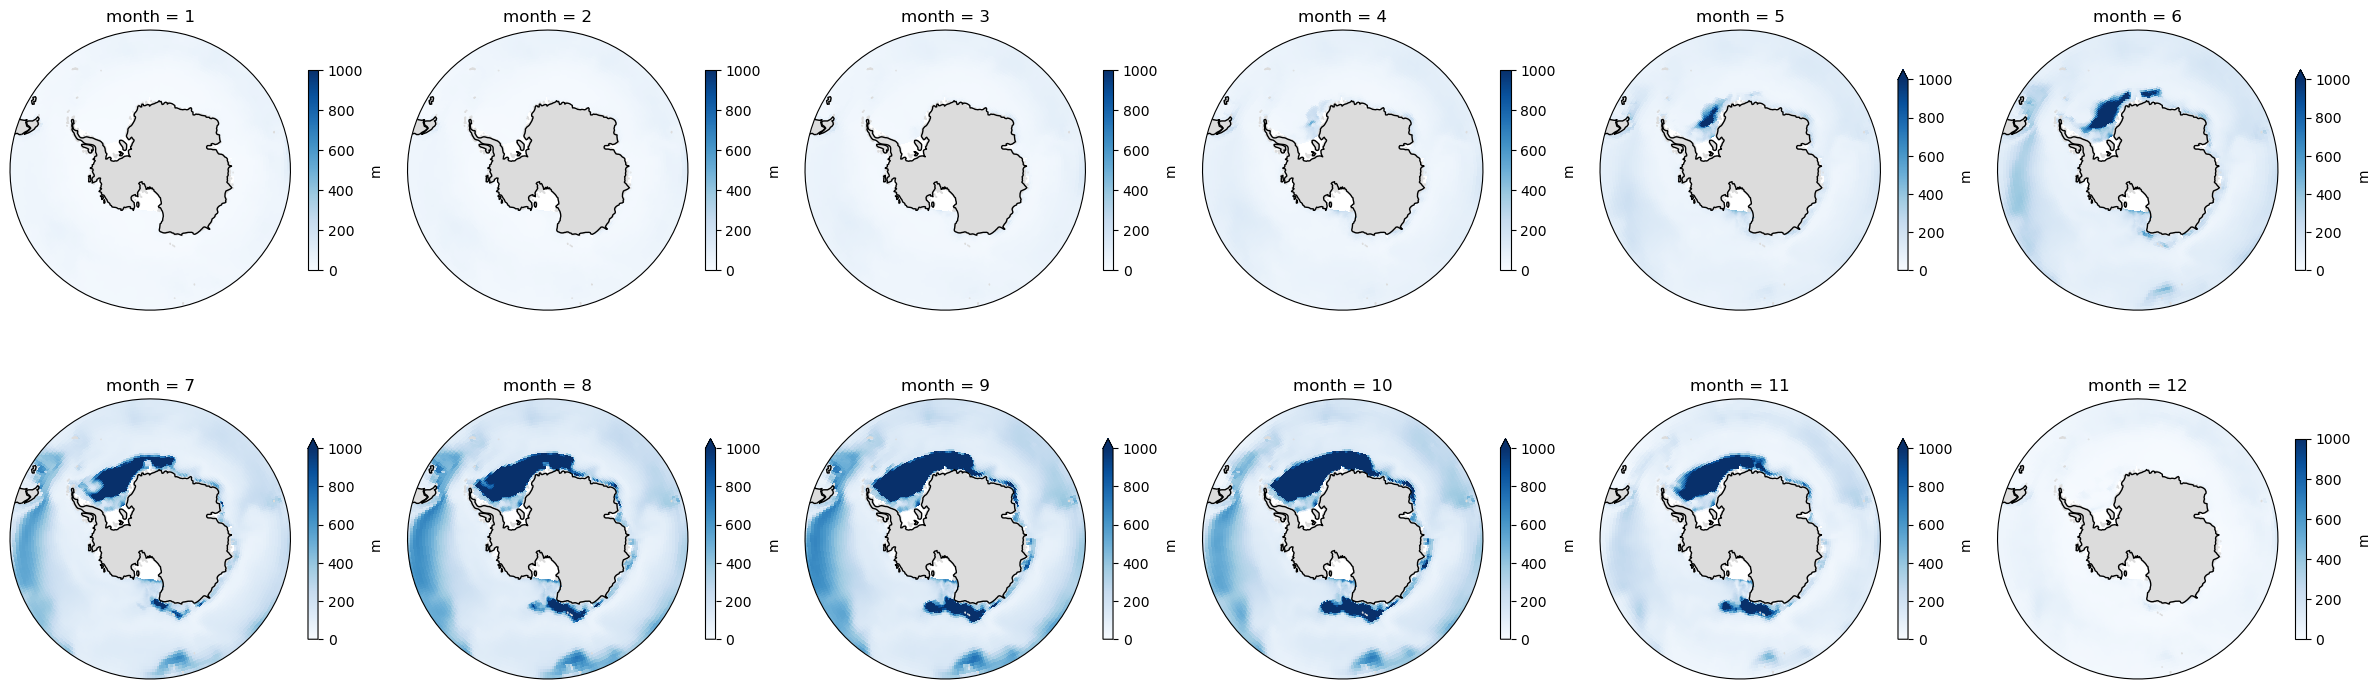

In [31]:
# Plot 12 months of mixed layer depth
fig, axs = plt.subplots(2, 6, subplot_kw = {'projection': ccrs.SouthPolarStereo()}, figsize = (24, 8))
axs = axs.flatten()
for ax in axs:
    ax = stereographic_axis(ax)
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
for m in ds['month']:
    ds['mld'].sel(month = m).plot(ax = axs[m-1], vmin = 0, vmax = 1000, cmap = 'Blues', transform = ccrs.PlateCarree(),
                                  cbar_kwargs = {'shrink':0.5, 'label':'m'})
plt.tight_layout();

In [32]:
ds_no_polynya = ds.sel(xt_ocean = slice(-150,150), yt_ocean = slice(-70,-55))
ice_no_polynya = ds_ice.sel(xt_ocean = slice(-150,150), yt_ocean = slice(-70,-55))

ds_polynya = ds.sel(xt_ocean = slice(-20,0), yt_ocean = slice(-70,-55))
ice_polynya = ds_ice.sel(xt_ocean = slice(-20,0), yt_ocean = slice(-70,-55))

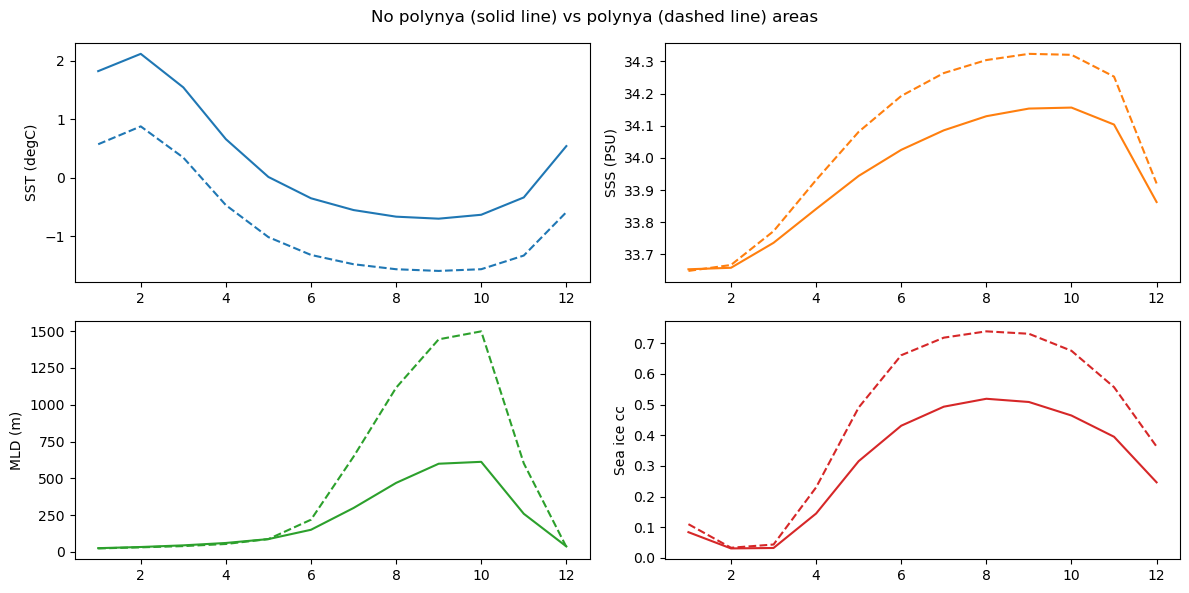

In [33]:
# Plot seasonal cycles
fig, axs = plt.subplots(2, 2, figsize = (12, 6))

ds_no_polynya['temp'].isel(st_ocean = 0).mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0,0], color = 'C0')
ds_polynya['temp'].isel(st_ocean = 0).mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0,0], color = 'C0', linestyle = '--')
ds_no_polynya['salt'].isel(st_ocean = 0).mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0,1], color = 'C1')
ds_polynya['salt'].isel(st_ocean = 0).mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[0,1], color = 'C1', linestyle = '--')
ds_no_polynya['mld'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1,0], color = 'C2')
ds_polynya['mld'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1,0], color = 'C2', linestyle = '--')
ice_no_polynya['aice_m'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1,1], color = 'C3')
ice_polynya['aice_m'].mean(['xt_ocean', 'yt_ocean']).plot(ax = axs[1,1], color = 'C3', linestyle = '--')
axs[0,0].set_ylabel('SST (degC)')
axs[0,1].set_ylabel('SSS (PSU)')
axs[1,0].set_ylabel('MLD (m)')
axs[1,1].set_ylabel('Sea ice cc')
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_title('')
fig.suptitle('No polynya (solid line) vs polynya (dashed line) areas');
plt.tight_layout();

We can see there is a lot more sea ice in the polynya areas, where its production makes the water saltier and colder, generating those very large mixed layer depths.